In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
from skimage.io import imread
from collections import defaultdict
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
read_hu = lambda x: imread(x).astype(np.float32)-32768

In [2]:
%matplotlib inline

In [3]:
def create_boxes(in_row):
    box_list = []
    for (start_x, start_y, end_x, end_y) in in_row['bbox']:
        box_list += [Rectangle((start_x, start_y), 
                         np.abs(end_x-start_x),
                         np.abs(end_y-start_y)
                         )]
    return box_list

In [4]:
image_dir = "minideeplesion/"

## Loading CSV

In [6]:
df = pd.read_csv("DL_info.csv")

## Cleaning

In [26]:
df = pd.read_csv('DL_info.csv')
df['df_path'] = df.apply(lambda c_row: os.path.join(image_dir, 
                                                        '{Patient_index:06d}_{Study_index:02d}_{Series_ID:02d}'.format(**c_row),
                                                        '{Key_slice_index:03d}.png'.format(**c_row)), 1)

print('Loaded', df.shape[0], 'cases')
df['exists'] = df['df_path'].map(os.path.exists)
df = df[df['exists']].drop('exists', 1)
# extact the bounding boxes
df['bbox'] = df['Bounding_boxes'].map(lambda x: np.reshape([float(y) for y in x.split(',')], (-1, 4)))
df['norm_loc'] = df['Normalized_lesion_location'].map(lambda x: np.reshape([float(y) for y in x.split(',')], (-1)))
df['Spacing_mm_px_'] = df['Spacing_mm_px_'].map(lambda x: np.reshape([float(y) for y in x.split(',')], (-1)))
df['Lesion_diameters_Pixel_'] = df['Lesion_diameters_Pixel_'].map(lambda x: np.reshape([float(y) for y in x.split(',')], (-1)))
df['Radius_x'] = df.apply(lambda x: x['Lesion_diameters_Pixel_'][0]*x['Spacing_mm_px_'][0], 1)
for i, ax in enumerate('xyz'):
    df[f'{ax}_loc'] = df['norm_loc'].map(lambda x: x[i])
print('Found', df.shape[0], 'patients with images')

Loaded 32735 cases
Found 1350 patients with images


## Grouping the patients scan together

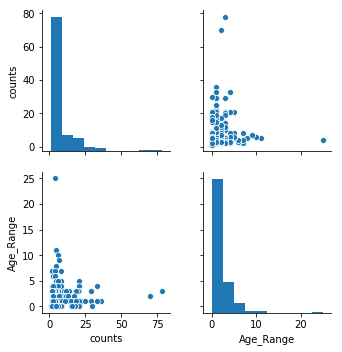

In [27]:
freq_flyers_df = df.groupby('Patient_index')[['Patient_age']].apply(
    lambda x: pd.Series({'counts': x.shape[0], 
                         'Age_Range': np.max(x['Patient_age'])-np.min(x['Patient_age'])})).reset_index().sort_values('Age_Range', ascending = False)
sns.pairplot(freq_flyers_df[['counts', 'Age_Range']])

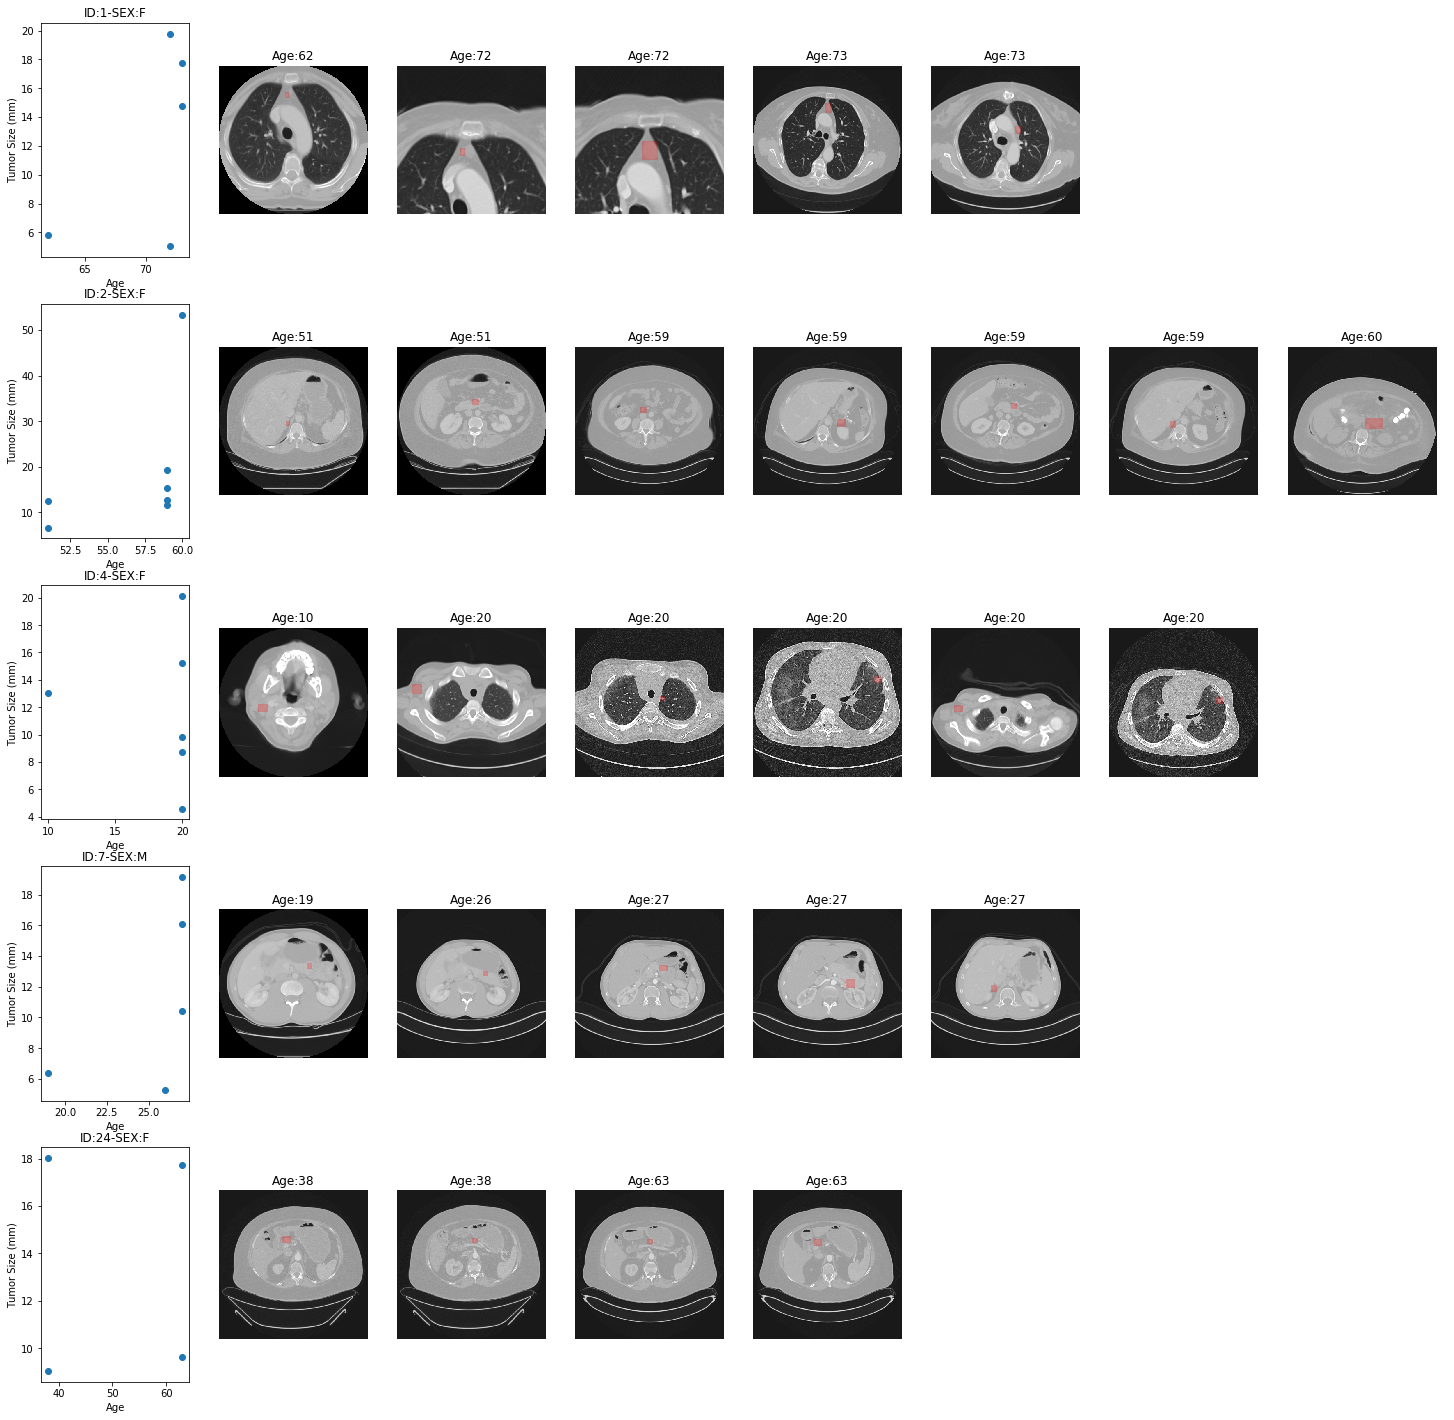

In [28]:
fig, m_axs = plt.subplots(5, 8, figsize = (25, 25))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
join_df = pd.merge(df, freq_flyers_df.head(5))
for n_axs, (_, c_df) in zip(m_axs, join_df.groupby('Patient_index')):
    _, t_row = next(c_df.iterrows())
    n_axs[0].scatter(c_df['Patient_age'], c_df['Radius_x'])
    n_axs[0].set_xlabel('Age')
    n_axs[0].set_ylabel('Tumor Size (mm)')
    n_axs[0].set_title('ID:{Patient_index}-SEX:{Patient_gender}'.format(**t_row))
    n_axs[0].axis('on')
    for c_ax, (_, c_row) in zip(n_axs[1:], c_df.sort_values('Study_index').iterrows()):
        c_img = read_hu(c_row['df_path'])
        c_ax.imshow(c_img, vmin = -1200, vmax = 600, cmap = 'gray')
        c_ax.add_collection(PatchCollection(create_boxes(c_row), alpha = 0.25, facecolor = 'red'))
        c_ax.set_title('Age:{Patient_age:1.0f}'.format(**c_row))
        c_ax.axis('off')
fig.savefig('overview.png', dpi = 300)

## Export Segmentations to HDF5

In [30]:
def create_segmentation(in_img, in_row):
    yy, xx = np.meshgrid(range(in_img.shape[0]),
               range(in_img.shape[1]),
               indexing='ij')
    out_seg = np.zeros_like(in_img)
    for (start_x, start_y, end_x, end_y) in in_row['bbox']:
        c_seg = (xx<end_x) & (xx>start_x) & (yy<end_y) & (yy>start_y)
        out_seg+=c_seg
    return np.clip(out_seg, 0, 1).astype(np.float32)

In [31]:
img_list = []
seg_list = []
path_list = []
from tqdm import tqdm_notebook
for (_, c_row) in tqdm_notebook(df.iterrows()):
    c_img = read_hu(c_row['df_path'])
    img_list+=[c_img]
    seg_list+=[create_segmentation(c_img, c_row).astype(bool)]
    path_list+=[c_row['File_name']]

In [32]:
from skimage.transform import resize
def smart_stack(in_list, *args, **kwargs):
    """
    Use the first element to determine the size for all the results and resize the ones that dont match
    """
    base_shape = in_list[0].shape
    return np.stack([x if x.shape==base_shape else resize(x, base_shape, preserve_range=True) for x in in_list], *args, **kwargs)

In [34]:
import h5py
with h5py.File('deeplesion.h5', 'w') as h:
    h.create_dataset('image', data=np.expand_dims(smart_stack(img_list, 0), -1), 
                     compression = 5)    
    h.create_dataset('mask', data=np.expand_dims(smart_stack(seg_list, 0), -1).astype(bool), 
                     compression = 5)    
    h.create_dataset('file_name', data=[x.encode('ascii') for x in path_list], 
                     compression = 0)    